In [25]:
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from tensorflow.distribute import MirroredStrategy
from keras.utils import Sequence
#from keras.models import load_model
import os
import matplotlib.pyplot as plt
import pickle
rng = np.random.default_rng()


Path = "/home/ug-ml/felix-ML/DataGenerator2/Data"
DataSets = ["/train/", "/validation/"]

In [26]:
class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\test_dir"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        return np.array([np.load(file_name) for file_name in paths])


In [ ]:
data = [i for i in gen_paths_labels(Path)]
#data[0][0] is training paths data[0][1] is training labels
#data[1][0] is val paths data[1][1] is val labels
print("data done.")
training_seq = FelixSequence(data[0][0], data[0][1], 32, "npy")
print("training_seq done.")
#print(data[1][0])
val_images = arrs_from_paths(data[1][0], "npy")
print("val_images done.")
val_lab = to_categorical(data[1][1])
print("val_lab done.")


data done.
training_seq done.


In [22]:
strategy = MirroredStrategy()

with strategy.scope():
    model = models.Sequential()
    model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', data_format='channels_first', input_shape=(36, 128, 128)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SeparableConv2D(128, (3, 3), data_format='channels_first', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SeparableConv2D(128, (3, 3), data_format='channels_first',  activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer = l2(0.0001)))
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer = l2(0.0001)))



    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0005), metrics=['acc'])
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

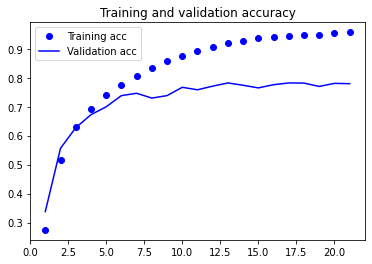

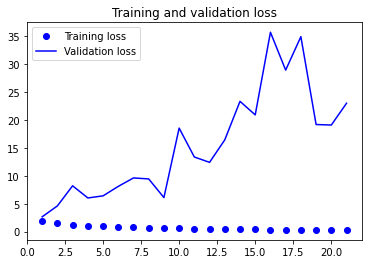

In [23]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#Checkpoint = ModelCheckpoint("3DCovBest.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

#model = models.load_model('F:\\training3000\\pngs_thicknesses_model_L2.h5')
#model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['acc'])


history = model.fit(training_seq, 
                    epochs=100, 
                    validation_data = (val_images, val_lab), 
                    callbacks=[EarlyStop], 
                    workers = 16, 
                    use_multiprocessing = False)

#model.save('3DCovLast.h5')

#test_loss, test_acc = model.evaluate(test_images, test_lab)

#with open('3DCovPICKLE', 'wb') as file_pi: pickle.dump(history.history, file_pi)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [24]:
model.save('Conv_seq_36_3000_1.h5')